# - Import modules -

In [1]:
import os, time, random, json
import numpy as np
from math import exp, cos, log
from tqdm import tqdm
import scipy.stats as stats

In [2]:
from matplotlib import pyplot as plt
import matplotlib
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20)
plt.rcParams["axes.labelweight"] = "bold"

# - Define functions -

In [3]:
## will create the files needed to store values in CWD/Data

def data_dir(dir="os.getcwd()"):
    
    if not os.path.exists('{}/{}'.format(os.getcwd(),'DataLIF')): # used to tag simulation results
        directory = os.path.dirname(dir)
        os.makedirs('{}/{}'.format(os.getcwd(),'DataLIF'))
        
    if not os.path.exists('DataLIF/{}'.format(timestr)):
        os.makedirs('DataLIF/{}'.format(timestr))

In [4]:
## function to get the index "-delay/dt" in the list representing m(t-Delta)

def delta(synapse_value, delay, t, dt,i):
    
    if t < delay:                           # if delay is too small, we take m(t-delta) = 0
        return 0
    
    else:                                   # if time above/equal delay,find the m(t-delta)
        return synapse_value[int(-delay / dt)][i]

In [5]:
## Initialization of the random generator (reproductibility)

w              = np.random.randint(1,10)

np.random.seed(w)

# - LIF initial parameters -

In [6]:
## setup parameters and state variables
n              = 1                              # number of neurons in population
K              = 1                              # Average number of neurons projecting

duration       = 1000                           # total time (msec)
dt             = 0.100                          # time step (msec)
times          = np.arange(0, duration+dt, dt)  # time array
n_period       = int(duration / dt) + 1         # Period occuring

t_rest         = 1                              # initial refractory time (msec)

In [7]:
## LIF properties

Vm             = np.zeros(len(times))-81        # potential trace over time (mV)
Rm             = 1                              # resistance (MOhm)

tau_m          = 20                             # dynamic time constant (msec) - #Rm*Cm
tau_ref        = 0.1                            # refractory period (msec)

V_th           = -42                            # spike threshold (mV)
V_spike        = 80                             # spike amplitude (mV)

In [8]:
## LIF Input properties

tau_d          = 3                              # time decay constant (msec)
tau_r          = 1                              # time rise constant (msec)

In [9]:
## MSN axonal parameters

J              = 1                              # Weight MSN-MSN
D              = 5                              # Delay MSN-MSN (ms)
M              = 3                              # Average basal activity (spikes/s) 

In [10]:
## Setup noise SD (N) and heterogeneity SD (TN)

N              = 0.5
TN             = 0

In [11]:
## Heterogeneity and Input trace 

T              = np.random.normal(0, TN, size = n)
I              = np.random.normal(0, N, size = n) + T

# - Set input stimulus - 

In [12]:
## Set Input for each step

I              = np.zeros(len(times))

In [13]:
## First Input stimulus

minI1           = 0.0                           # beggining time (ms)
maxI1           = 100.0                         # End input (ms)
Input           = 0.0                           # input current (A)

In [14]:
## Second Input stimulus

minI2          = 500.0                         # beggining time (ms)
maxI2          = 900.0                         # End input (ms)
Input2         = 100                           # input current (pA)

In [15]:
## Set Input defined above between min-max

I[ int(minI1/dt) : int(maxI1/dt)+1 ]           += Input
I[ int(minI2/dt) : int(maxI2/dt)+1 ]           += Input2

In [16]:
# Il = np.random.normal(10,5,len(time)) # for random/noisy inputs

# need to define external input for basal activity with dynamic equation

# - Simulation Core -

In [17]:
def kappa(t, tau_o):
    
    return exp(-(t/tau_o))

In [18]:
it = 0

nspike = np.zeros( int( duration/dt ) + 1 )

In [19]:
## iterate over each time step

for i, t in enumerate(times):
    
## Input update

    I[it] += - J/K * tau_m/(tau_d-tau_r) * (kappa(t,tau_d) - kappa(t,tau_r)) #+ H

    
    #* delta(m[:t + 1], D, times[t], dt) #
    
    
    
## memb.Potential update    
    
    if t > t_rest:
        
        Vm[i] = Vm[i-1] + I[it] / tau_m * dt + I[it]*Rm / tau_m * dt**2 + np.random.normal(0, N)
        
        if Vm[i] >= V_th:
            
            nspike[it] = 1
    
    
    
    if Vm[i] >= V_th:
       
        Vm[i] += V_spike
        t_rest = t + tau_ref
    
    

    
    it += 1

# - Firing rate calculation (window) - 

# - Savedata - 

In [21]:
timestr = time.strftime("%Y-%m-%d-%H:%M:%S")                           # date & time used to tag simulation
data_dir()                                                             # create 'Data' directory in CWD

np.save('DataLIF/{}/{}_Inputs'.format(timestr, 'MSN'), I)              # save Input array
np.save('DataLIF/{}/{}_mPot'.format(timestr,'MSN' ), Vm)               # save mPotential 

datax={'Weight':J,'Delay':D,'tau_m':tau_m,'Noise':N,                   # creat dict with parameters used 
       'time_trial':t,'duration':duration,'step':dt}

with open('DataLIF/{}/0_Parameters.json'.format(timestr),'w') as f:    # save parameters dict 
            json.dump(datax, f) 

# - Plotting- 

In [22]:
## Membrane potential and Input trace
fig = plt.figure(figsize=(15,10))

## 1st AXIS                         ====================================

ax1 = plt.subplot(311)
#ax1.set_ylim(0,2)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_ylabel('Input [A]',fontsize=15,fontweight='bold')
plt.plot(times,I,'b',linewidth=2)


## 2nd AXIS:                        ====================================

ax2 = plt.subplot(312, sharex=ax1)
#ax2.set_ylim(0,2)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set_ylabel('M.potential [V]',fontsize=15,fontweight='bold')
ax2.plot(times, Vm,'g',linewidth=2)
ax2.plot((times[0], duration), (V_th, V_th), 'r',linestyle=':', dashes=(1, 5))   # plot treshold level

plt.setp(ax1.get_xticklabels(), visible=False)

# make these tick labels invisible
plt.setp(ax2.get_xticklabels(), visible=False)


## 3rd AXIS                         ====================================

ax3 = plt.subplot(313, sharex=ax1)
#ax3.set_ylim(2,5)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.set_ylabel('Firing rate [Hz]',fontsize=15,fontweight='bold')
ax3.set_xlabel('Time [ms]',fontsize=15,fontweight='bold')
plt.plot(times, Vm,'r',linewidth=2)

plt.autoscale(enable=True, axis='x', tight=True)

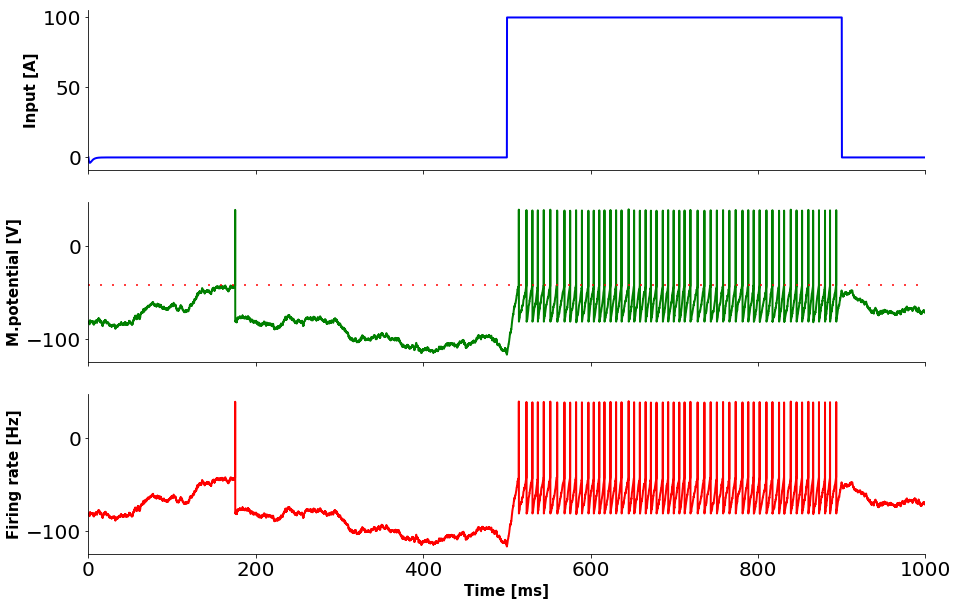

In [23]:
## Save and show plots

plt.savefig('DataLIF/{}/I&Mp72.png'.format(timestr),dpi=72,bbox_inches='tight')
plt.savefig('DataLIF/{}/I&Mp150.png'.format(timestr),dpi=150,bbox_inches='tight')
plt.savefig('DataLIF/{}/I&Mp300.png'.format(timestr),dpi=300,bbox_inches='tight')

plt.show()

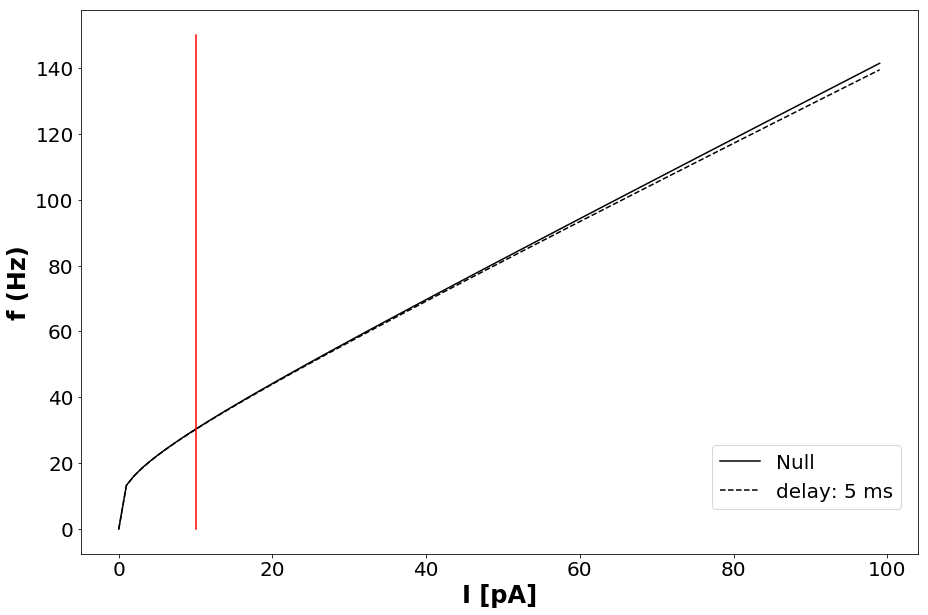

In [24]:
f1=np.zeros(100)
f2=np.zeros(100)

xi=np.arange(0,100)

for x in np.arange(1,100):
    f1[x] = 1.0 / (0 - tau_m * log(x/(x - V_th)))       *1000 # To convert in Hz
    f2[x] = 1.0 / (tau_ref - tau_m * log(x/(x - V_th))) *1000 # To convert in Hz


fig = plt.figure(figsize=(15,10))
plt.plot(xi,f1,'k-',label='Null')
plt.plot(xi,f2,'k--',label='delay: '+str(D)+' ms')
plt.plot([10, 10],[0, 150],'r-')
plt.xlabel('I [pA]',fontsize=24)
plt.ylabel('f (Hz)',fontsize=24)
plt.legend(bbox_to_anchor=(0.98, 0.20), loc=0, borderaxespad=0.,prop={'size':20})
#plt.yticks([0,.1,.2,.3])

plt.show()